In [143]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

% matplotlib inline

In [8]:
# Create a Dataframe and drop extra column
df = pd.read_csv('./data/seattle_911_prepped.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df_no_out = pd.read_csv('./data/seattle_911_prepped_no_out.csv', low_memory=False)
df_no_out.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,day_num,neighborhood,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,11747 Bartlett Av Ne,Medic Response,2010-06-29 08:00:00,47.713787,-122.283848,NaN,NaN,06/29/2010 08:00:00 AM,2010-06-29,08:00:00,...,0,Matthews Beach,0,1,0,0,0,0,0,1.824157
1,700 6th Av S,Aid Response,2010-06-29 07:49:00,47.596676,-122.326370,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,International District,0,0,0,0,1,0,0,1.824157
2,7751 26th Av Nw,Aid Response,2010-06-29 07:49:00,47.685264,-122.389777,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,Loyal Heights,1,0,0,0,0,0,0,1.824157
3,5241 33rd Av S,Aid Response,2010-06-29 07:50:00,47.554718,-122.290486,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Mid-Beacon Hill,0,0,0,0,0,0,1,1.824157
4,509 3rd Av,Auto Fire Alarm,2010-06-29 07:50:00,47.602114,-122.330809,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Pioneer Square,0,0,0,0,1,0,0,1.824157


In [9]:
df2 = df.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                 'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                 'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2_no_out = df_no_out.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                 'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                 'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,Wednesday,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.824157
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.824157
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.824157
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.824157
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.824157


In [10]:
df2.to_csv('./data/model_data.csv')
df2_no_out.to_csv('./data/model_data_no_out.csv')

# Modeling

In [142]:
# R used to fix dataframe for Poisson model
df3 = pd.read_csv('./data/model_data_counted_no_out.csv', low_memory=False)
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
df3.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality,freq
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1.824157,20
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.824157,35
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.824157,30
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.824157,18
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1.824157,15


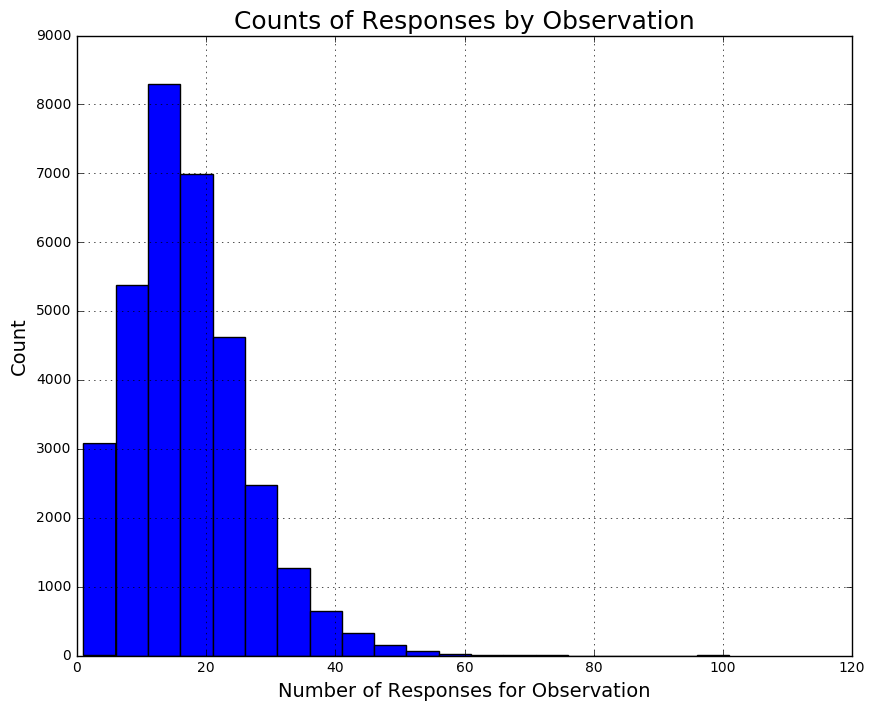

In [28]:
plt.figure(figsize=(10,8))
df3.freq.hist(bins=20)
plt.title('Counts of Responses by Observation', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Responses for Observation', fontsize=14)

In [29]:
df3.day_num.max()

2304

In [154]:
# Create test and trainging sets
df_train = df3[df3.day_num < 1938]
df_holdout = df3[(df3.day_num >= 1938) & (df3.day_num <= 2304)]

# Create X and y
y_train = df_train.pop('freq')
X_train = df_train
y_holdout = df_holdout.pop('freq')
X_holdout = df_holdout

KF = KFold(len(df_train), n_folds=5, shuffle=False, random_state=None)

for train_index, test_index in KF:
    print("TRAIN:", train_index, "TEST:", test_index)

# Scale X
# scaler = StandardScaler(with_mean=False)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

('TRAIN:', array([ 5537,  5538,  5539, ..., 27681, 27682, 27683]), 'TEST:', array([   0,    1,    2, ..., 5534, 5535, 5536]))
('TRAIN:', array([    0,     1,     2, ..., 27681, 27682, 27683]), 'TEST:', array([ 5537,  5538,  5539, ..., 11071, 11072, 11073]))
('TRAIN:', array([    0,     1,     2, ..., 27681, 27682, 27683]), 'TEST:', array([11074, 11075, 11076, ..., 16608, 16609, 16610]))
('TRAIN:', array([    0,     1,     2, ..., 27681, 27682, 27683]), 'TEST:', array([16611, 16612, 16613, ..., 22145, 22146, 22147]))
('TRAIN:', array([    0,     1,     2, ..., 22145, 22146, 22147]), 'TEST:', array([22148, 22149, 22150, ..., 27681, 27682, 27683]))


In [193]:
summary = []
params = []
predict = []
y_tests = []
for train_index, test_index in KF:
    model = Poisson(y_train[train_index], X_train.ix[train_index]).fit()
    summary.append(model.summary())
    params.append(model.params)
    predict.append(model.predict(X_train.ix[test_index]))
    y_tests.append(y_train[test_index])

Optimization terminated successfully.
         Current function value: 2.854618
         Iterations 34
Optimization terminated successfully.
         Current function value: 3.189193
         Iterations 34
Optimization terminated successfully.
         Current function value: 3.191943
         Iterations 33
Optimization terminated successfully.
         Current function value: 3.171290
         Iterations 33
Optimization terminated successfully.
         Current function value: 3.173745
         Iterations 31


In [189]:
def score(y_test, y_hat):
    return (((y_hat - y_test) / y_test) ** 2).mean()

In [195]:
for i, y_test in enumerate(y_tests):
    print score(y_test, predict[i])

2.08139678676
0.293517813255
0.156515805651
0.249356281986
0.170689634377


In [194]:
params

[mariners_home    0.001849
 seahawks_home   -0.039703
 sounders_home    0.005695
 trav_holiday    -0.087387
 dang_holiday     0.123305
 night            0.367368
 Monday          -0.021118
 Saturday         0.016669
 Sunday          -0.000415
 Thursday        -0.030978
 Tuesday         -0.035018
 Wednesday       -0.020117
 day_num          0.000156
 zone1            2.570337
 zone2            2.352409
 zone3            1.943692
 zone4            2.516791
 zone5            2.916239
 zone6            2.136654
 zone7            2.302691
 seasonality      0.055121
 dtype: float64, mariners_home   -0.005664
 seahawks_home   -0.033763
 sounders_home    0.003166
 trav_holiday    -0.033793
 dang_holiday     0.134522
 night            0.291914
 Monday          -0.020644
 Saturday         0.020090
 Sunday          -0.000928
 Thursday        -0.026733
 Tuesday         -0.040393
 Wednesday       -0.020274
 day_num          0.000152
 zone1            2.615023
 zone2            2.403316
 zone3      

In [173]:
model = Poisson(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 3.118516
         Iterations 33


In [174]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   freq   No. Observations:                27684
Model:                        Poisson   Df Residuals:                    27663
Method:                           MLE   Df Model:                           20
Date:                Mon, 14 Nov 2016   Pseudo R-squ.:                  0.3409
Time:                        15:41:56   Log-Likelihood:                -86333.
converged:                       True   LL-Null:                   -1.3099e+05
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
mariners_home    -0.0029      0.004     -0.820      0.412        -0.010     0.004
seahawks_home    -0.0311      0.011     -2.948      0.003        -0.052    -0.010
sounders_home     0.0055      0.007      0.770      0.441        -0.009     0.020
trav_holiday     -0.0322      0.013     -2.575      0.010        -0.057    -0.008
dang_holiday      0.1294      0.018      7.042      0.000         0.093     0.165
night             0.3115      0.003    103.552      0.000         0.306     0.317
Monday           -0.0288      0.006     -5.194      0.000        -0.040    -0.018
Saturday          0.0197      0.006      3.529      0.000         0.009     0.031
Sunday            0.0006      0.006      0.098      0.922        -0.011     0.012
Thursday         -0.0308      0.006     -5.546      0.000        -0.042    -0.020
Tuesday          -0.0424      0.006     -7.657      0.000        -0.053    -0.032
Wednesday        -0.0264      0.006     -4.790      0.000        -0.037    -0.016
day_num           0.0002   2.69e-06     57.759      0.000         0.000     0.000
zone1             2.6058      0.006    408.916      0.000         2.593     2.618
zone2             2.3881      0.007    360.342      0.000         2.375     2.401
zone3             1.9791      0.007    273.129      0.000         1.965     1.993
zone4             2.5535      0.006    397.142      0.000         2.541     2.566
zone5             2.9378      0.006    484.609      0.000         2.926     2.950
zone6             2.1754      0.007    314.150      0.000         2.162     2.189
zone7             2.3442      0.007    350.670      0.000         2.331     2.357
seasonality       0.0573      0.002     25.922      0.000         0.053     0.062
=================================================================================
"""

In [27]:
y_hat = model.predict(X_test) 

In [152]:
score(y_test, y_hat)

0.18973866557711133

In [150]:
mean_squared_error(y_test, y_hat)

24.313549254315017

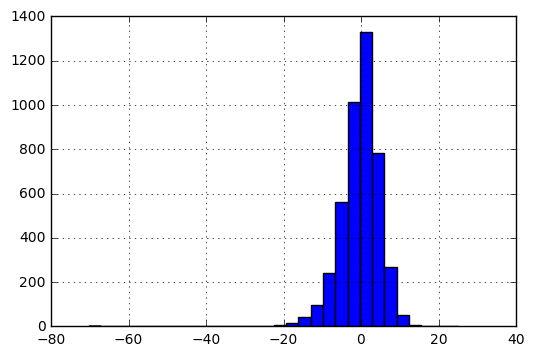

In [33]:
differences = y_hat - y_test
differences.hist(bins=30)

In [103]:
model_reg1 = Poisson(y_train, X_train).fit_regularized(method='l1', alpha=600)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.51088447115
            Iterations: 26
            Function evaluations: 37
            Gradient evaluations: 26
QC check did not pass for 1 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


In [170]:
model_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   freq   No. Observations:                28632
Model:                        Poisson   Df Residuals:                    28611
Method:                           MLE   Df Model:                           20
Date:                Mon, 14 Nov 2016   Pseudo R-squ.:                  0.3431
Time:                        15:26:41   Log-Likelihood:                -90331.
converged:                       True   LL-Null:                   -1.3751e+05
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
mariners_home     0.0008      0.003      0.237      0.812        -0.006     0.008
seahawks_home -7.889e-18      0.010  -7.69e-16      1.000        -0.020     0.020
sounders_home  4.028e-17      0.007   5.63e-15      1.000        -0.014     0.014
trav_holiday  -1.011e-17      0.011  -8.99e-16      1.000        -0.022     0.022
dang_holiday  -3.023e-17      0.019  -1.61e-15      1.000        -0.037     0.037
night             0.3068      0.003    104.145      0.000         0.301     0.313
Monday        -2.896e-16      0.005   -5.3e-14      1.000        -0.011     0.011
Saturday          0.0389      0.005      7.082      0.000         0.028     0.050
Sunday            0.0179      0.006      3.157      0.002         0.007     0.029
Thursday       3.133e-16      0.005   5.74e-14      1.000        -0.011     0.011
Tuesday       -1.411e-16      0.005   -2.6e-14      1.000        -0.011     0.011
Wednesday     -4.746e-16      0.005  -8.74e-14      1.000        -0.011     0.011
day_num           0.0002   2.08e-06     78.681      0.000         0.000     0.000
zone1             2.5492      0.006    411.906      0.000         2.537     2.561
zone2             2.3227      0.006    360.037      0.000         2.310     2.335
zone3             1.9171      0.007    271.584      0.000         1.903     1.931
zone4             2.4939      0.006    399.112      0.000         2.482     2.506
zone5             2.8940      0.006    492.811      0.000         2.882     2.906
zone6             2.1116      0.007    313.130      0.000         2.098     2.125
zone7             2.2673      0.007    347.553      0.000         2.254     2.280
seasonality       0.0680      0.002     31.264      0.000         0.064     0.072
=================================================================================
"""

In [105]:
y_hat_reg1 = model_reg1.predict(X_test) 

In [106]:
mean_squared_error(y_test, y_hat_reg1)

24.035734717400882

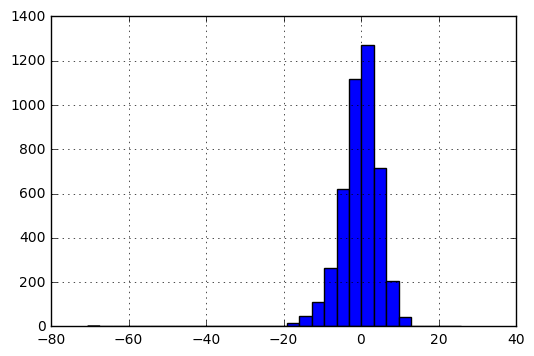

In [107]:
differences_reg1 = y_hat_reg1 - y_test
differences_reg1.hist(bins=30)

In [141]:
diffs = (y_hat_reg1 - y_test)
for i, v in diffs.iteritems():
    print '{}  {}  {}'.format(y_test[i], y_test[i] + v, v) 

37  30.9694308409  -6.03056915907
20  20.7561716528  0.756171652839
12  8.57847893631  -3.42152106369
17  16.5481991157  -0.451800884319
10  12.8695375748  2.86953757482
29  22.7865591943  -6.21344080575
15  16.1405210298  1.14052102978
9  10.4205383202  1.42053832018
15  15.2718897691  0.271889769066
13  12.1757652133  -0.824234786733
16  14.1626534345  -1.83734656553
16  17.4911117769  1.49111177693
9  11.6590928834  2.65909288338
11  21.9367367187  10.9367367187
1  1.71428058138  0.714280581379
32  21.546491947  -10.453508053
37  22.3811964595  -14.6188035405
10  10.2351615867  0.23516158667
8  12.6405942358  4.6405942358
7  8.42587161845  1.42587161845
20  15.8533883526  -4.14661164742
47  30.4184984657  -16.5815015343
17  13.9107061405  -3.08929385951
18  15.000209655  -2.99979034504
17  11.9591637754  -5.04083622457
20  17.1799526921  -2.82004730785
13  16.253814027  3.253814027
8  11.4516828161  3.45168281607
21  20.3869286077  -0.613071392284
22  22.3795470443  0.379547044266
1

In [153]:
score(y_test, y_hat_reg1)

0.19145314844149872

# Other Models

In [19]:
model_boosting = GradientBoostingRegressor(subsample=0.5, n_estimators=10000, learning_rate=0.001)

In [20]:
model_boosting.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [21]:
y_hat_boost = model_boosting.predict(X_test)

In [22]:
mean_squared_error(y_test, y_hat_boost)

30.693052991046358

In [23]:
model_forest = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features='sqrt')

In [24]:
model_forest.fit(X_train, y_train, )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [25]:
y_hat_for = model_forest.predict(X_test)

In [26]:
mean_squared_error(y_test, y_hat_for)

26.096926519196025